In [5]:
import os
import pandas as pd
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GroupKFold
from PIL import Image

In [6]:
DATA_DIR = '/kaggle/input/skin-cancer-mnist-ham10000'

In [7]:
# Example: If uploaded to /content/ham10000/
#DATA_DIR = '/content/drive/MyDrive/CSE465/dataset'  # change this as needed
IMG_DIR1 = os.path.join(DATA_DIR, 'HAM10000_images_part_1')
IMG_DIR2 = os.path.join(DATA_DIR, 'HAM10000_images_part_2') # Corrected directory name
METADATA_CSV = os.path.join(DATA_DIR, 'HAM10000_metadata.csv')

In [8]:
# Example: listing files in first folder to verify
print(f"Number of images in part1: {len(os.listdir(IMG_DIR1))}")
print(f"Number of images in part2: {len(os.listdir(IMG_DIR2))}")
print(f"Metadata CSV Path: {METADATA_CSV}")

Number of images in part1: 5000
Number of images in part2: 5015
Metadata CSV Path: /kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv


In [9]:
# 1) Load metadata CSV
df = pd.read_csv(METADATA_CSV)
print("Metadata head:")
print(df.head())

Metadata head:
     lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear


In [10]:
# 2) Check classes and distribution
print("\nClass distribution:")
print(df['dx'].value_counts())


Class distribution:
dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64


In [11]:
# Map class codes to full names if needed (optional)
class_names = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'bkl': 'Benign keratosis-like lesions',
    'df': 'Dermatofibroma',
    'vasc': 'Vascular lesions'
}


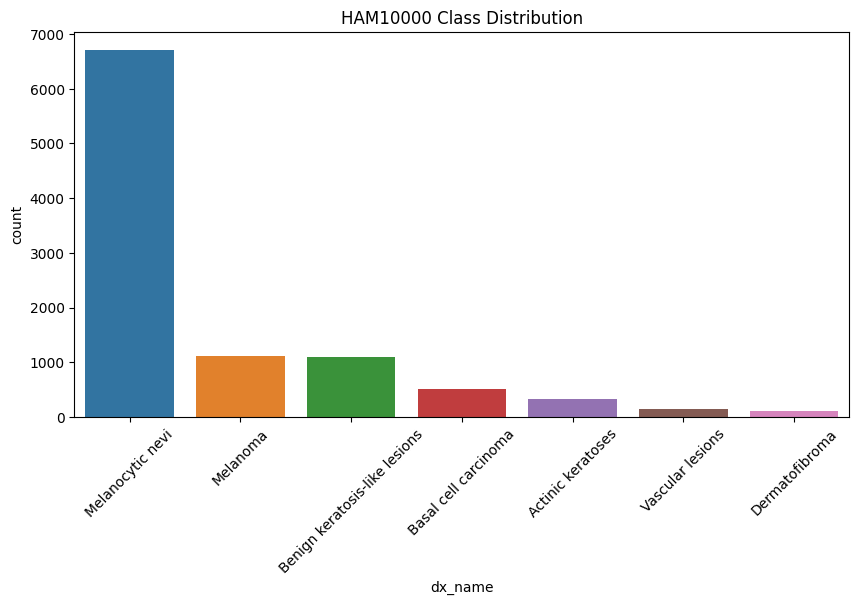

In [12]:
df['dx_name'] = df['dx'].map(class_names)

# Plot class distribution
plt.figure(figsize=(10,5))
sns.countplot(data=df, x='dx_name', order=df['dx_name'].value_counts().index)
plt.xticks(rotation=45)
plt.title('HAM10000 Class Distribution')
plt.show()

In [13]:
# 7) Prepare GroupKFold splits by lesion_id (stratified by dx)
gkf = GroupKFold(n_splits=5)

df['fold'] = -1
X = df.index.values
y = df['dx'].values
groups = df['lesion_id'].values

for fold, (train_idx, val_idx) in enumerate(gkf.split(X, y, groups)):
    df.loc[val_idx, 'fold'] = fold

print("\nFold distribution:")
print(df['fold'].value_counts())


Fold distribution:
fold
0    2003
2    2003
1    2003
3    2003
4    2003
Name: count, dtype: int64


In [14]:
OUTPUT_PATH = '/kaggle/working/ham10000_metadata_folds.csv'
df.to_csv(OUTPUT_PATH, index=False)
print(f"Saved fold assignments to {OUTPUT_PATH}")


Saved fold assignments to /kaggle/working/ham10000_metadata_folds.csv


In [15]:
import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms
from PIL import Image
import pandas as pd
import os
import numpy as np

In [16]:
 
# Paths
DATA_DIR = '/kaggle/input/skin-cancer-mnist-ham10000'
IMG_DIR1 = os.path.join(DATA_DIR, 'HAM10000_images_part_1')
IMG_DIR2 = os.path.join(DATA_DIR, 'HAM10000_images_part_2')

# If folds file is generated in THIS notebook
METADATA_CSV2 = '/kaggle/working/ham10000_metadata_folds.csv'

# If folds file already exists in dataset uploaded to Kaggle
# METADATA_CSV2 = os.path.join(DATA_DIR, 'ham10000_metadata_folds.csv')




In [17]:
# Load CSV with folds (generated in Phase 1)
df = pd.read_csv(METADATA_CSV2)

In [18]:
# Map classes to indices
class_names = sorted(df['dx'].unique())
class_to_idx = {cls: idx for idx, cls in enumerate(class_names)}
idx_to_class = {idx: cls for cls, idx in class_to_idx.items()}

print("Class to index mapping:", class_to_idx)

Class to index mapping: {'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


In [19]:
df.head(1)

,lesion_id,image_id,dx,dx_type,age,sex,localization,dx_name,fold
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,0


In [20]:
# ---------------------------
# Image Transforms
# ---------------------------
train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=30),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.05, hue=0.05),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [21]:
# ---------------------------
# Dataset Class
# ---------------------------
class HAM10000Dataset(Dataset):
    def __init__(self, dataframe, img_dir1, img_dir2, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.img_dir1 = img_dir1
        self.img_dir2 = img_dir2
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_filename = row['image_id'] + '.jpg'

        img_path1 = os.path.join(self.img_dir1, img_filename)
        img_path2 = os.path.join(self.img_dir2, img_filename)

        if os.path.exists(img_path1):
            img_path = img_path1
        elif os.path.exists(img_path2):
            img_path = img_path2
        else:
            raise FileNotFoundError(f"Image {img_filename} not found in either folder.")

        image = Image.open(img_path).convert("RGB")
        label = class_to_idx[row['dx']]

        if self.transform:
            image = self.transform(image)

        return image, label

In [22]:
# ---------------------------
# Create DataLoaders
# ---------------------------
def get_dataloaders(fold, batch_size=32, use_sampler=True):
    train_df = df[df['fold'] != fold]
    val_df = df[df['fold'] == fold]

    train_dataset = HAM10000Dataset(train_df, IMG_DIR1, IMG_DIR2, transform=train_transforms)
    val_dataset = HAM10000Dataset(val_df, IMG_DIR1, IMG_DIR2, transform=val_transforms)

    if use_sampler:
        class_counts = train_df['dx'].value_counts().to_dict()
        class_weights = {cls: 1.0/count for cls, count in class_counts.items()}
        sample_weights = [class_weights[row['dx']] for _, row in train_df.iterrows()]
        sampler = WeightedRandomSampler(weights=sample_weights,
                                        num_samples=len(sample_weights),
                                        replacement=True)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
    else:
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader

In [23]:
# ---------------------------
# Example: Load fold 0
# ---------------------------
train_loader, val_loader = get_dataloaders(fold=0, batch_size=32)

# Check one batch
images, labels = next(iter(train_loader))
print("Batch images shape:", images.shape)
print("Batch labels:", labels)

Batch images shape: torch.Size([32, 3, 224, 224])
Batch labels: tensor([2, 0, 6, 3, 0, 1, 2, 4, 1, 2, 2, 2, 6, 1, 1, 2, 1, 3, 6, 6, 6, 2, 5, 6,
        2, 4, 5, 5, 2, 0, 1, 4])


# Student Model 1

In [24]:
#!pip install timm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
import timm
import copy
import time
from torchvision import models
import os

In [25]:
import torch, torch.nn as nn, torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.metrics import f1_score, balanced_accuracy_score
import copy, csv, os

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

# -----------------------
# Tiny Student (<300k params) — depthwise-separable CNN
# -----------------------
class DWConvBlock(nn.Module):
    def __init__(self, in_c, out_c, stride=1):
        super().__init__()
        self.depth = nn.Conv2d(in_c, in_c, 3, stride, 1, groups=in_c, bias=False)
        self.point = nn.Conv2d(in_c, out_c, 1, 1, 0, bias=False)
        self.bn = nn.BatchNorm2d(out_c)
        self.act = nn.SiLU(inplace=True)
    def forward(self, x):
        x = self.depth(x); x = self.point(x); x = self.bn(x); x = self.act(x)
        return x

class StudentNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        # If params >300k, reduce channels a bit; if <<200k and weak, increase slightly.
        self.stem = nn.Sequential(
            nn.Conv2d(3, 24, 3, 2, 1, bias=False), nn.BatchNorm2d(24), nn.SiLU(inplace=True)
        )
        self.stage = nn.Sequential(
            DWConvBlock(24, 32, 1),
            DWConvBlock(32, 48, 2),
            DWConvBlock(48, 64, 1),
            DWConvBlock(64, 96, 2),
            DWConvBlock(96, 128, 1),
            DWConvBlock(128, 160, 2),
        )
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.head = nn.Linear(160, num_classes)

    def forward(self, x):
        x = self.stem(x)
        x = self.stage(x)
        x = self.pool(x).flatten(1)
        return self.head(x)

def count_params(m):
    return sum(p.numel() for p in m.parameters() if p.requires_grad)

# -----------------------
# Init
# -----------------------
num_classes = len(class_to_idx)  # your mapping
student = StudentNet(num_classes).to(device)
print("Student params (trainable):", count_params(student))

criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
optimizer = optim.AdamW(student.parameters(), lr=2e-3, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=30)

epochs = 30
best_val_acc = 0.0
best_wts = copy.deepcopy(student.state_dict())
save_dir = "/kaggle/working"
supervised_ckpt = os.path.join(save_dir, "student_supervised_best.pth")
metrics_csv = os.path.join(save_dir, "supervised_metrics.csv")

# CSV header
with open(metrics_csv, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["epoch","train_acc","val_acc","val_bal_acc","val_macro_f1"])

# -----------------------
# Train
# -----------------------
for epoch in range(epochs):
    # ---- Train ----
    student.train()
    train_correct = train_total = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        logits = student(x)
        loss = criterion(logits, y)
        optimizer.zero_grad(); loss.backward(); optimizer.step()

        pred = logits.argmax(1)
        train_correct += (pred == y).sum().item()
        train_total += y.size(0)
    scheduler.step()
    train_acc = 100.0 * train_correct / train_total

    # ---- Validate ----
    student.eval()
    val_correct = val_total = 0
    all_preds, all_trues = [], []
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            logits = student(x)
            pred = logits.argmax(1)
            val_correct += (pred == y).sum().item()
            val_total += y.size(0)
            all_preds.append(pred.cpu())
            all_trues.append(y.cpu())

    import torch as T
    all_preds = T.cat(all_preds).numpy()
    all_trues = T.cat(all_trues).numpy()
    val_acc = 100.0 * val_correct / val_total
    val_bal_acc = balanced_accuracy_score(all_trues, all_preds) * 100.0
    val_macro_f1 = f1_score(all_trues, all_preds, average="macro") * 100.0

    print(f"Epoch {epoch+1}/{epochs} | "
          f"train_acc={train_acc:.2f}% | val_acc={val_acc:.2f}% | "
          f"bal_acc={val_bal_acc:.2f}% | macroF1={val_macro_f1:.2f}%")

    with open(metrics_csv, "a", newline="") as f:
        writer = csv.writer(f)
        writer.writerow([epoch+1, f"{train_acc:.2f}", f"{val_acc:.2f}", f"{val_bal_acc:.2f}", f"{val_macro_f1:.2f}"])

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_wts = copy.deepcopy(student.state_dict())
        torch.save(best_wts, supervised_ckpt)
        print(f"✅ New best (supervised). Saved to {supervised_ckpt}")

student.load_state_dict(best_wts)
print("Supervised training done. Best val_acc:", best_val_acc)


Using: cuda
Student params (trainable): 50695
Epoch 1/30 | train_acc=39.15% | val_acc=47.68% | bal_acc=47.22% | macroF1=36.98%
✅ New best (supervised). Saved to /kaggle/working/student_supervised_best.pth
Epoch 2/30 | train_acc=47.68% | val_acc=49.58% | bal_acc=54.15% | macroF1=33.72%
✅ New best (supervised). Saved to /kaggle/working/student_supervised_best.pth
Epoch 3/30 | train_acc=51.56% | val_acc=63.21% | bal_acc=56.31% | macroF1=40.39%
✅ New best (supervised). Saved to /kaggle/working/student_supervised_best.pth
Epoch 4/30 | train_acc=54.24% | val_acc=63.21% | bal_acc=57.74% | macroF1=45.19%
Epoch 5/30 | train_acc=56.34% | val_acc=60.06% | bal_acc=55.85% | macroF1=46.98%
Epoch 6/30 | train_acc=59.52% | val_acc=58.16% | bal_acc=58.71% | macroF1=46.54%
Epoch 7/30 | train_acc=61.48% | val_acc=62.46% | bal_acc=60.07% | macroF1=47.84%
Epoch 8/30 | train_acc=61.45% | val_acc=57.76% | bal_acc=63.45% | macroF1=44.86%
Epoch 9/30 | train_acc=64.04% | val_acc=59.41% | bal_acc=58.39% | macroF

In [25]:
#Evaluation of student 1

from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, accuracy_score
import torch as T

# -----------------------
# 1. Print trainable parameter count
# -----------------------
print("Total trainable parameters:", count_params(student))

# -----------------------
# 2. Evaluate on validation set with detailed metrics
# -----------------------
student.eval()
all_preds, all_trues = [], []
with torch.no_grad():
    for x, y in val_loader:
        x, y = x.to(device), y.to(device)
        logits = student(x)
        pred = logits.argmax(1)
        all_preds.append(pred.cpu())
        all_trues.append(y.cpu())

# Convert to numpy arrays
all_preds = T.cat(all_preds).numpy()
all_trues = T.cat(all_trues).numpy()

# Metrics
acc = accuracy_score(all_trues, all_preds) * 100
prec = precision_score(all_trues, all_preds, average='macro') * 100
rec = recall_score(all_trues, all_preds, average='macro') * 100
f1 = f1_score(all_trues, all_preds, average='macro') * 100

print(f"Accuracy : {acc:.2f}%")
print(f"Precision: {prec:.2f}%")
print(f"Recall   : {rec:.2f}%")
print(f"F1-score : {f1:.2f}%")

# Optional: per-class metrics
print("\nClassification Report:")
print(classification_report(all_trues, all_preds, target_names=list(class_to_idx.keys())))


Total trainable parameters: 50695
Accuracy : 69.70%
Precision: 50.07%
Recall   : 67.82%
F1-score : 55.65%

Classification Report:
              precision    recall  f1-score   support

       akiec       0.28      0.71      0.41        56
         bcc       0.39      0.57      0.46       108
         bkl       0.49      0.58      0.53       239
          df       0.24      0.57      0.33        23
         mel       0.47      0.64      0.54       226
          nv       0.96      0.73      0.83      1319
        vasc       0.68      0.94      0.79        32

    accuracy                           0.70      2003
   macro avg       0.50      0.68      0.56      2003
weighted avg       0.78      0.70      0.72      2003



# Student 2

In [26]:
# ============================
# Student-only training (HAM10000)
# Tiny CNN (120k–180k params), class-weighted CE, optional MixUp
# Needs: train_loader, val_loader, class_to_idx
# ============================

import os, copy, numpy as np
from collections import Counter

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.metrics import f1_score, balanced_accuracy_score


In [29]:
# ----------------------------
# Config
# ----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(class_to_idx)

EPOCHS = 50
LR = 2e-3
WEIGHT_DECAY = 1e-4
LABEL_SMOOTH = 0.05
WIDTH_MULT = 1.5          # tweak 0.9–1.1 to stay between 120k–180k params
MIXUP_ALPHA = 0.2         # set 0.0 to disable MixUp
EARLY_STOP_PATIENCE = 10  # early stop on macro-F1
CKPT_PATH = "/kaggle/working/student_supervised_best2.pth"

print(f"Device: {device} | Classes: {num_classes}")

# ----------------------------
# Model
# ----------------------------
class DSBlock(nn.Module):
    """Depthwise separable conv block with BN, SiLU, light dropout and residual (when shapes match)."""
    def __init__(self, in_c, out_c, stride=1, pdrop=0.05):
        super().__init__()
        self.dw = nn.Conv2d(in_c, in_c, 3, stride, 1, groups=in_c, bias=False)
        self.pw = nn.Conv2d(in_c, out_c, 1, 1, 0, bias=False)
        self.bn = nn.BatchNorm2d(out_c)
        self.act = nn.SiLU(inplace=True)
        self.drop = nn.Dropout2d(pdrop) if pdrop > 0 else nn.Identity()
        self.use_res = (stride == 1 and in_c == out_c)

    def forward(self, x):
        y = self.dw(x)
        y = self.pw(y)
        y = self.bn(y)
        y = self.act(y)
        y = self.drop(y)
        return y + x if self.use_res else y

class StudentNet(nn.Module):
    """Tiny CNN: stem + a few DS blocks, global pool, linear head."""
    def __init__(self, num_classes, width_mult=1.0):
        super().__init__()
        # Base channel plan (scaled by width_mult)
        base = [32, 48, 64, 96, 128, 160]
        ch = [max(8, int(c * width_mult)) for c in base]

        self.stem = nn.Sequential(
            nn.Conv2d(3, ch[0], 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ch[0]),
            nn.SiLU(inplace=True),
        )
        self.stage = nn.Sequential(
            DSBlock(ch[0], ch[0], stride=1),
            DSBlock(ch[0], ch[1], stride=2),
            DSBlock(ch[1], ch[1], stride=1),
            DSBlock(ch[1], ch[2], stride=2),
            DSBlock(ch[2], ch[2], stride=1),
            DSBlock(ch[2], ch[3], stride=2),
            DSBlock(ch[3], ch[3], stride=1),
            DSBlock(ch[3], ch[4], stride=1),
            DSBlock(ch[4], ch[5], stride=1),
        )
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.head = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(ch[5], num_classes)
        )

    def forward(self, x):
        x = self.stem(x)
        x = self.stage(x)
        x = self.pool(x).flatten(1)
        return self.head(x)

def count_params(m):
    return sum(p.numel() for p in m.parameters() if p.requires_grad)

# ----------------------------
# Class weights (handle imbalance)
# ----------------------------
@torch.no_grad()
def compute_class_weights_from_loader(loader, num_classes):
    counts = np.zeros(num_classes, dtype=np.int64)
    for _, y in loader:
        y = y.cpu().numpy()
        counts += np.bincount(y, minlength=num_classes)
    # inverse frequency, normalized to mean=1 for stability
    counts = np.maximum(counts, 1)
    inv_freq = (counts.sum() / (num_classes * counts))
    w = torch.tensor(inv_freq, dtype=torch.float32, device=device)
    return w

# ----------------------------
# MixUp
# ----------------------------
def mixup(x, y, alpha=0.2):
    if alpha <= 0:
        return x, y, y, 1.0
    lam = np.random.beta(alpha, alpha)
    idx = torch.randperm(x.size(0), device=x.device)
    mixed_x = lam * x + (1 - lam) * x[idx]
    y_a, y_b = y, y[idx]
    return mixed_x, y_a, y_b, float(lam)

# ----------------------------
# Init: model, loss, opt, sched
# ----------------------------
student = StudentNet(num_classes, width_mult=WIDTH_MULT).to(device)
print(f"Trainable params: {count_params(student):,}")

class_weights = compute_class_weights_from_loader(train_loader, num_classes)
criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=LABEL_SMOOTH)

optimizer = optim.AdamW(student.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS)

best_macro_f1 = -1.0
best_wts = copy.deepcopy(student.state_dict())
no_improve = 0

# ----------------------------
# Train / Validate
# ----------------------------
for epoch in range(1, EPOCHS + 1):
    # ---- Train ----
    student.train()
    train_correct, train_total = 0, 0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)

        # MixUp (optional)
        xb_mixed, ya, yb_shuf, lam = mixup(xb, yb, alpha=MIXUP_ALPHA)
        logits = student(xb_mixed)

        if MIXUP_ALPHA > 0:
            loss = lam * criterion(logits, ya) + (1 - lam) * criterion(logits, yb_shuf)
        else:
            loss = criterion(logits, yb)

        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(student.parameters(), max_norm=5.0)
        optimizer.step()

        # Rough train accuracy (uses original labels even when mixed)
        with torch.no_grad():
            pred = logits.argmax(1)
            train_correct += (pred == yb).sum().item()
            train_total += yb.size(0)

    scheduler.step()
    train_acc = 100.0 * train_correct / max(1, train_total)

    # ---- Validate ----
    student.eval()
    val_correct, val_total = 0, 0
    preds, trues = [], []

    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            out = student(xb)
            p = out.argmax(1)
            val_correct += (p == yb).sum().item()
            val_total += yb.size(0)
            preds.append(p.cpu())
            trues.append(yb.cpu())

    preds = torch.cat(preds).numpy()
    trues = torch.cat(trues).numpy()

    val_acc = 100.0 * val_correct / max(1, val_total)
    val_bal_acc = balanced_accuracy_score(trues, preds) * 100.0
    val_macro_f1 = f1_score(trues, preds, average="macro") * 100.0

    print(f"Epoch {epoch:02d}/{EPOCHS} | "
          f"train_acc={train_acc:.2f}% | val_acc={val_acc:.2f}% | "
          f"bal_acc={val_bal_acc:.2f}% | macroF1={val_macro_f1:.2f}%")

    # Early stopping on macro-F1
    if val_macro_f1 > best_macro_f1:
        best_macro_f1 = val_macro_f1
        best_wts = copy.deepcopy(student.state_dict())
        torch.save(best_wts, CKPT_PATH)
        print(f"  ✅ New best macro-F1: {best_macro_f1:.2f}. Saved -> {CKPT_PATH}")
        no_improve = 0
    else:
        no_improve += 1
        if no_improve >= EARLY_STOP_PATIENCE:
            print("  ⏹ Early stopping triggered.")
            break

# load best
student.load_state_dict(best_wts)
print(f"Done. Best macro-F1: {best_macro_f1:.2f}")


Device: cuda | Classes: 7
Trainable params: 148,855
Epoch 01/50 | train_acc=25.81% | val_acc=25.01% | bal_acc=42.74% | macroF1=23.44%
  ✅ New best macro-F1: 23.44. Saved -> /kaggle/working/student_supervised_best2.pth
Epoch 02/50 | train_acc=30.52% | val_acc=56.62% | bal_acc=53.70% | macroF1=40.07%
  ✅ New best macro-F1: 40.07. Saved -> /kaggle/working/student_supervised_best2.pth
Epoch 03/50 | train_acc=33.50% | val_acc=62.36% | bal_acc=57.79% | macroF1=43.93%
  ✅ New best macro-F1: 43.93. Saved -> /kaggle/working/student_supervised_best2.pth
Epoch 04/50 | train_acc=35.42% | val_acc=57.61% | bal_acc=55.80% | macroF1=37.95%
Epoch 05/50 | train_acc=34.97% | val_acc=60.71% | bal_acc=58.86% | macroF1=39.85%
Epoch 06/50 | train_acc=37.43% | val_acc=66.45% | bal_acc=62.12% | macroF1=49.92%
  ✅ New best macro-F1: 49.92. Saved -> /kaggle/working/student_supervised_best2.pth
Epoch 07/50 | train_acc=37.38% | val_acc=68.90% | bal_acc=62.92% | macroF1=49.13%
Epoch 08/50 | train_acc=38.43% | val_a

In [31]:
torch.save(student, "student_full_model.pth")


In [30]:
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Load best weights
student.load_state_dict(torch.load(CKPT_PATH))
student.eval()

# Count params
def count_params(m):
    return sum(p.numel() for p in m.parameters() if p.requires_grad)
print(f"Trainable parameters: {count_params(student):,}")

# Collect predictions and labels
all_preds, all_trues = [], []
with torch.no_grad():
    for xb, yb in val_loader:
        xb, yb = xb.to(device), yb.to(device)
        out = student(xb)
        preds = out.argmax(dim=1)
        all_preds.append(preds.cpu())
        all_trues.append(yb.cpu())

all_preds = torch.cat(all_preds).numpy()
all_trues = torch.cat(all_trues).numpy()

# Calculate metrics
acc = accuracy_score(all_trues, all_preds) * 100
prec = precision_score(all_trues, all_preds, average='macro') * 100
rec = recall_score(all_trues, all_preds, average='macro') * 100
f1 = f1_score(all_trues, all_preds, average='macro') * 100

print(f"Validation Accuracy : {acc:.2f}%")
print(f"Validation Precision: {prec:.2f}%")
print(f"Validation Recall   : {rec:.2f}%")
print(f"Validation F1-score : {f1:.2f}%")

# Optional: detailed per-class report
print("\nClassification Report:\n")
print(classification_report(all_trues, all_preds, target_names=list(class_to_idx.keys())))


Trainable parameters: 148,855
Validation Accuracy : 71.29%
Validation Precision: 53.96%
Validation Recall   : 72.24%
Validation F1-score : 59.99%

Classification Report:

              precision    recall  f1-score   support

       akiec       0.29      0.79      0.42        56
         bcc       0.48      0.63      0.54       108
         bkl       0.47      0.54      0.50       239
          df       0.50      0.70      0.58        23
         mel       0.47      0.65      0.54       226
          nv       0.96      0.75      0.84      1319
        vasc       0.62      1.00      0.76        32

    accuracy                           0.71      2003
   macro avg       0.54      0.72      0.60      2003
weighted avg       0.79      0.71      0.74      2003

